In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 250
mtx_opt_path = "C:/Users/Tobias Bodmer/OneDrive - bwedu/KIT_temp/ourBenchmarks/ours_timingMtxMultithread.npy"
mtx_unopt_path = "C:/Users/Tobias Bodmer/OneDrive - bwedu/KIT_temp/ourBenchmarks/ours_timingMatrix_noPrecalc_1627137494.npy"
mtx_singleThread_path = "C:/Users/Tobias Bodmer/OneDrive - bwedu/KIT_temp/ourBenchmarks/ours_timingMatrix_singleTh_1627098825.npy"
mtx_ref_path = "C:/Users/Tobias Bodmer/OneDrive - bwedu/KIT_temp/ourBenchmarks/reference_timingMatrix1627218015.npy"
taxa_values = [125, 1481, 218, 714, 141, 24, 885, 2000, 354, 1604, 2308, 350, 1288, 1512, 2554, 1908, 150, 143, 148, 404, 500, 628, 994]
tree_values = [2,10,50,100,130]
max_taxa_val = 1000
plot_store_path = "C:/Users/Tobias Bodmer/Documents/RF_Metrics/misc/plots/"
# arrays have the dimensions [numberofTrees_idx][File / number_taxa_id][metric]


In [2]:
# load matrix from file and sort
opt = np.load(mtx_opt_path, allow_pickle=True)*1e-9
unopt = np.load(mtx_unopt_path, allow_pickle=True)*1e-9
singleTh = np.load(mtx_singleThread_path, allow_pickle=True)*1e-9
ref = np.load(mtx_ref_path, allow_pickle=True)*1e-9

num_taxa = np.array(taxa_values)
perm = np.argsort(num_taxa)
num_taxa = num_taxa[perm]
opt = opt[:,perm,:]
unopt = unopt[:,perm,:]
singleTh = singleTh[:,perm,:]
ref = ref[:,perm,:]

In [3]:
# remove too large taxa entries
t_mask = np.where(num_taxa <= max_taxa_val)
num_taxa = num_taxa[t_mask]
opt = opt[:,t_mask,:][:,0,:,:]
unopt = unopt[:,t_mask,:][:,0,:,:]
singleTh = singleTh[:,t_mask,:][:,0,:,:]
ref = ref[:,t_mask,:][:,0,:,:]

In [4]:
def deleteZeroRows(inArr):
    rowsToDelete = []
    for i in range(np.shape(inArr)[0]):
        if not np.any(inArr[i]):
            rowsToDelete.append(i)
    return np.delete(inArr, rowsToDelete, 0)
def getInvalidMask(inArr):
    bad_values = [0.,-1e-9,-2e-9] # not evaluated | error | timeout
    negativeMask = np.isin(inArr,bad_values)
    return ~negativeMask
def getTimeoutMask(inArr):
    bad_values = [-2e-9]
    negativeMask = np.isin(inArr,bad_values)
    return ~negativeMask
def getErrMask(inArr):
    bad_values = [-1e-9,0]
    negativeMask = np.isin(inArr,bad_values)
    return ~negativeMask

In [5]:
# analysis of data without plotting in this segment
# the metrics are nearly equally fast.

# find instances where larger tree count was faster?
# tree count is quasi transitive

# taxa is too scary to predict... just try until either fails

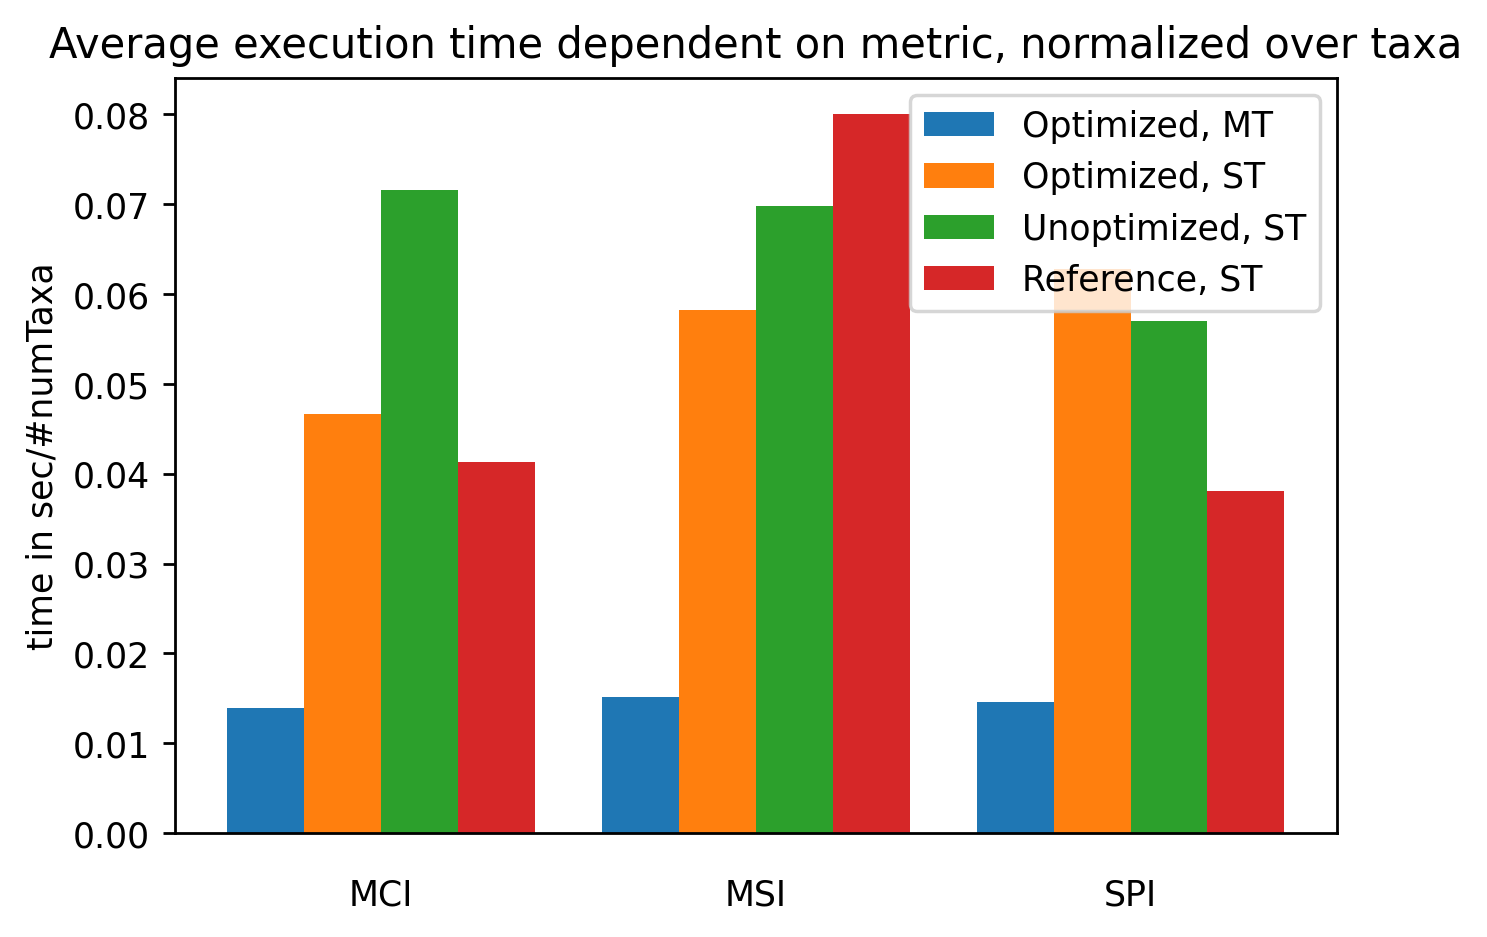

In [14]:
invM_opt = np.all(getInvalidMask(opt),axis=2)
invM_unopt = np.all(getInvalidMask(unopt),axis=2)
invM_sth = np.all(getInvalidMask(singleTh),axis=2)
invM_ref = np.all(getInvalidMask(ref),axis=2)

taxa_mat = np.dstack([num_taxa]*len(tree_values))[0].T
invTaxa_opt = 1/taxa_mat[invM_opt]
invTaxa_unopt = 1/taxa_mat[invM_unopt]
invTaxa_sth = 1/taxa_mat[invM_sth]
invTaxa_ref = 1/taxa_mat[invM_ref]


weightTaxa_opt = np.einsum('ta,ta->ta',opt[invM_opt], invTaxa_opt[...,np.newaxis])
weightTaxa_unopt = np.einsum('ta,ta->ta',unopt[invM_unopt], invTaxa_unopt[...,np.newaxis])
weightTaxa_sth = np.einsum('ta,ta->ta',singleTh[invM_sth], invTaxa_sth[...,np.newaxis])
weightTaxa_ref = np.einsum('ta,ta->ta',ref[invM_ref], invTaxa_ref[...,np.newaxis])

plt.bar([-5.1,-1.2,2.7], np.average(weightTaxa_opt,axis=0), label="Optimized, MT")
plt.bar([-4.3,-.4,3.5], np.average(weightTaxa_sth,axis=0), label="Optimized, ST")
plt.bar([-3.5,.4,4.3], np.average(weightTaxa_unopt,axis=0), label="Unoptimized, ST")
plt.bar([-2.7,1.2,5.1], np.average(weightTaxa_ref,axis=0), label="Reference, ST")


plt.text(-3.9, -0.008, "MCI", ha='center')
plt.text(0, -0.008, "MSI", ha='center')
plt.text(3.9, -0.008, "SPI", ha='center')

plt.ylabel("time in sec/#numTaxa")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
plt.title("Average execution time dependent on metric, normalized over taxa")
plt.legend()
plt.savefig(plot_store_path+"metricTimes",dpi=300,facecolor='white', transparent=False)
plt.show()


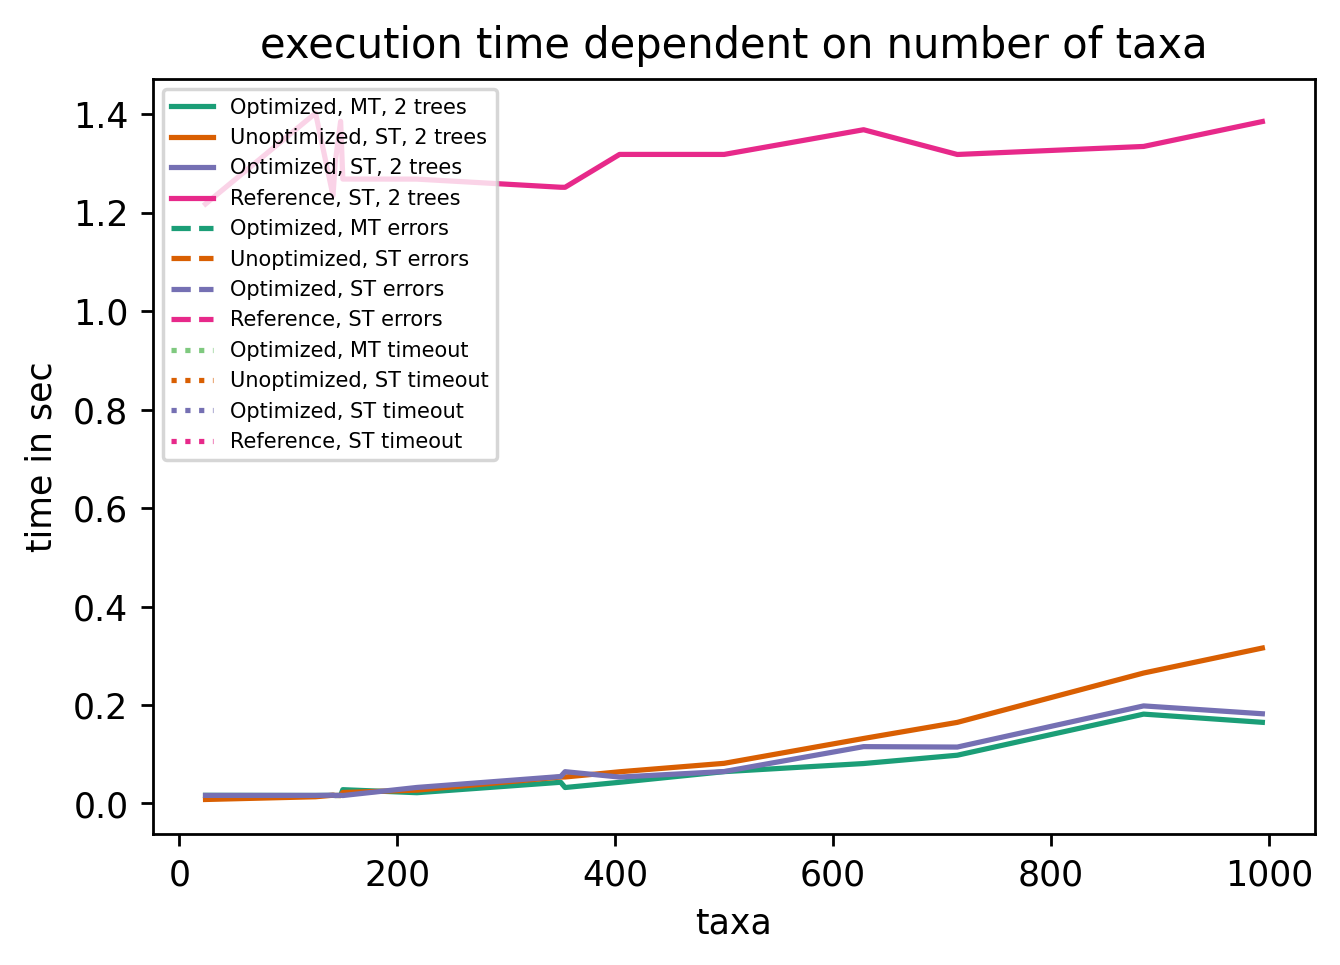

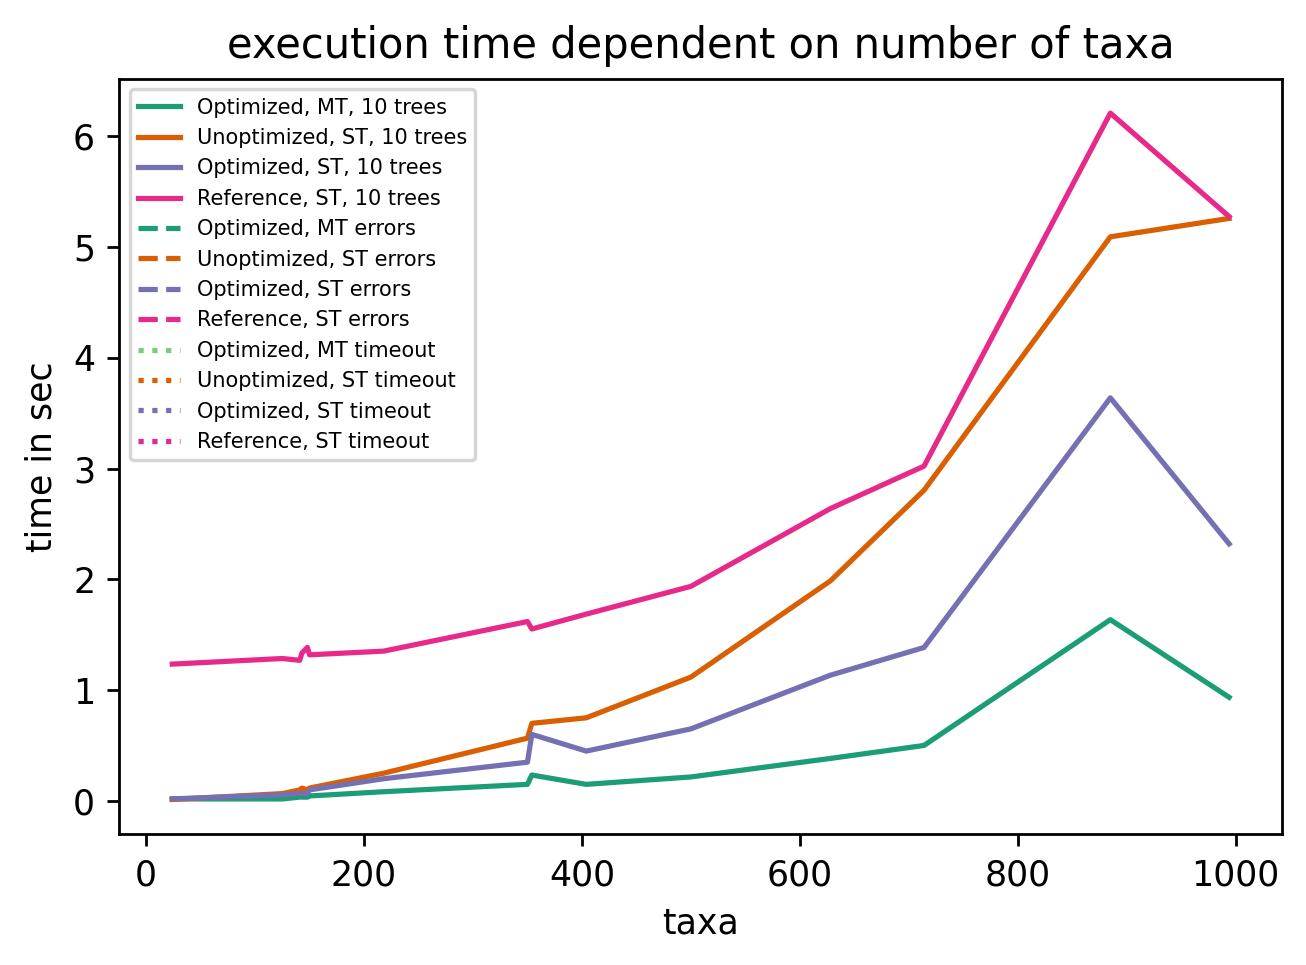

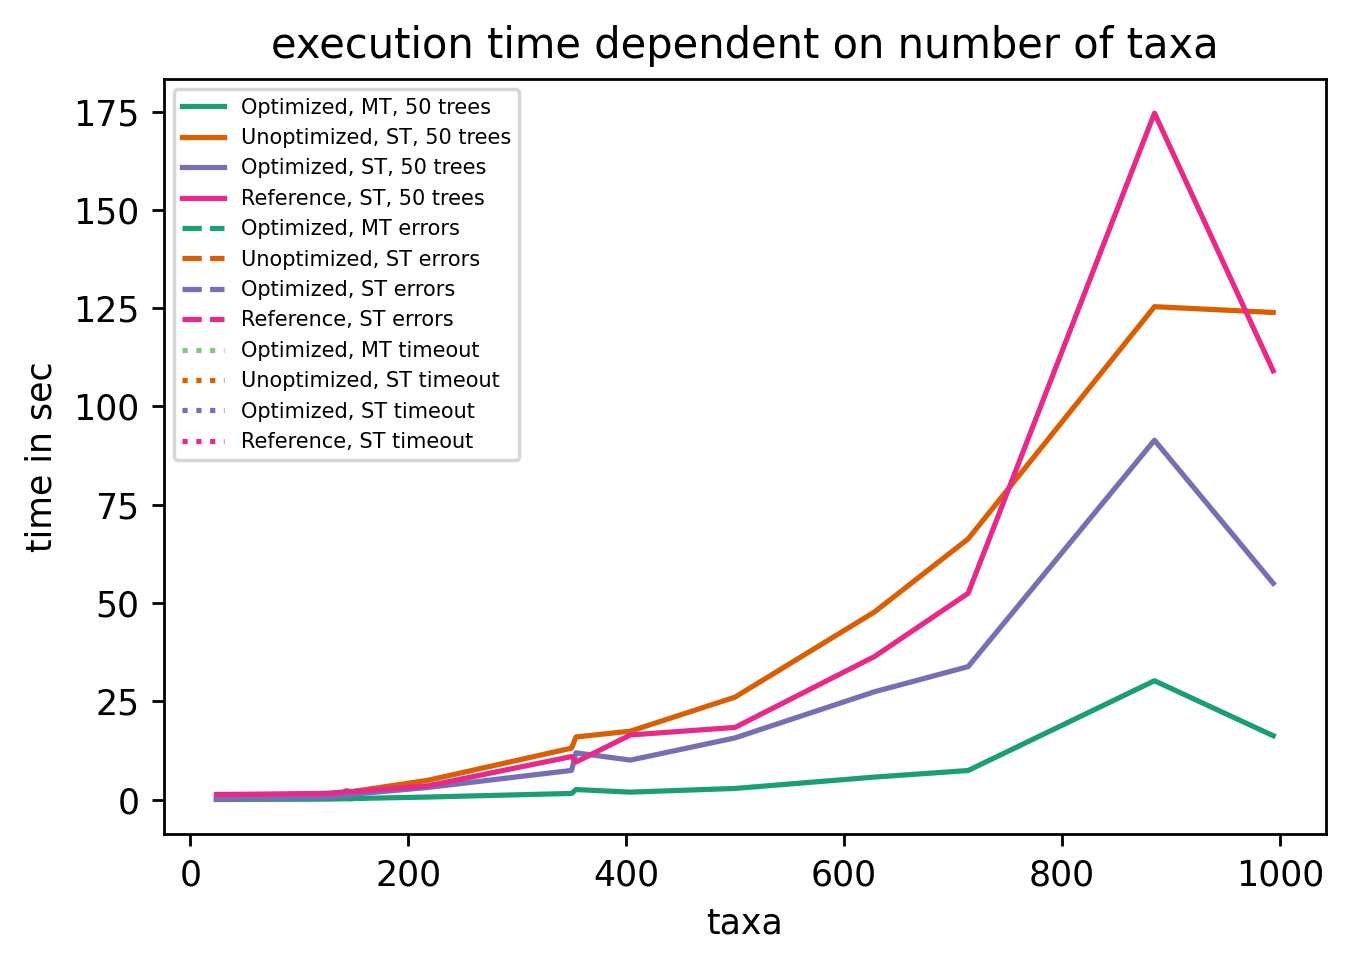

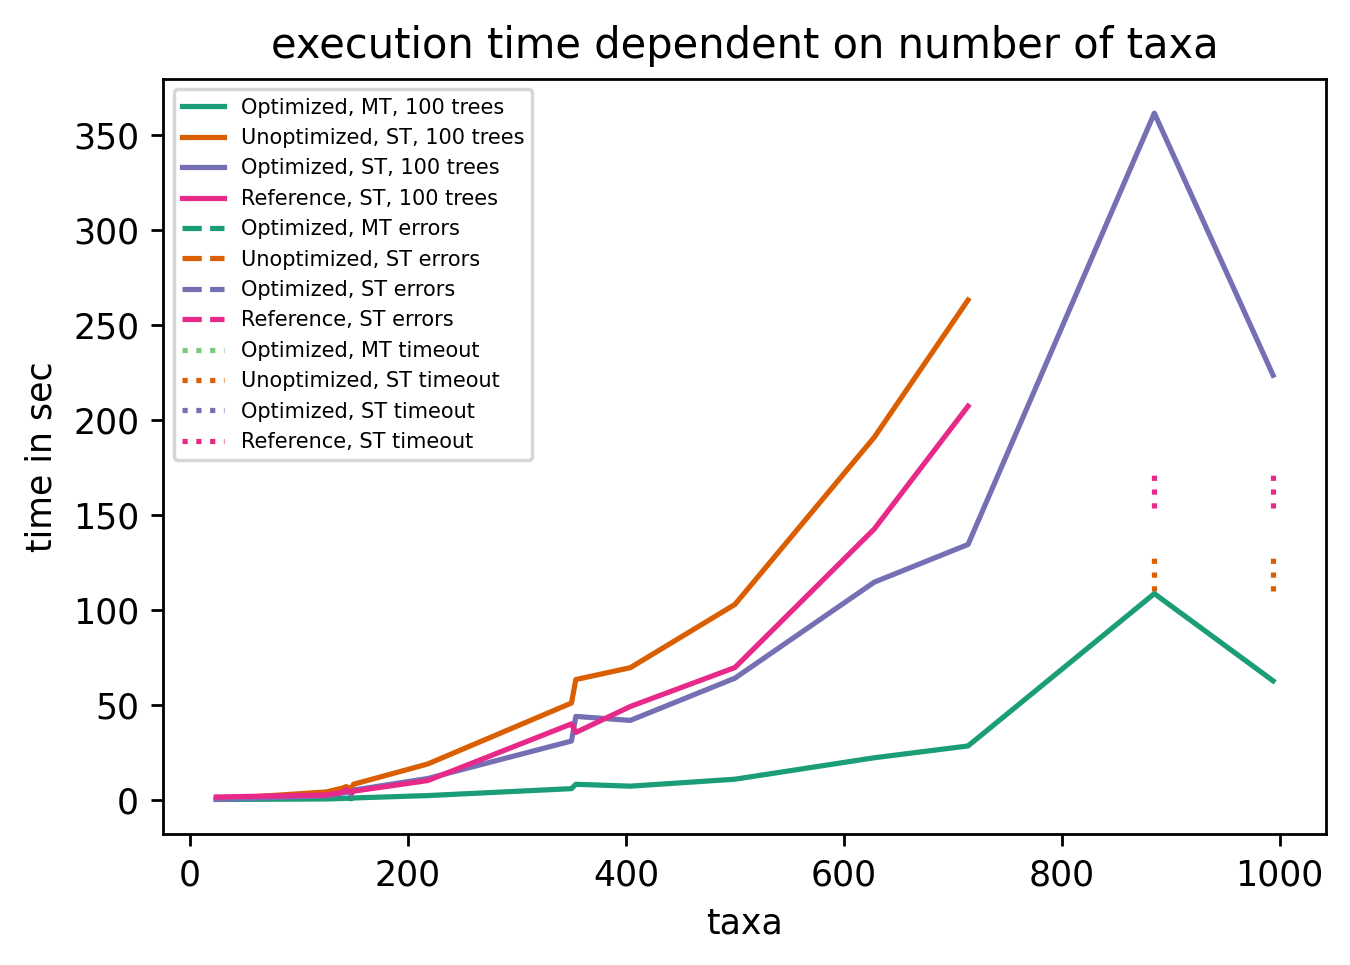

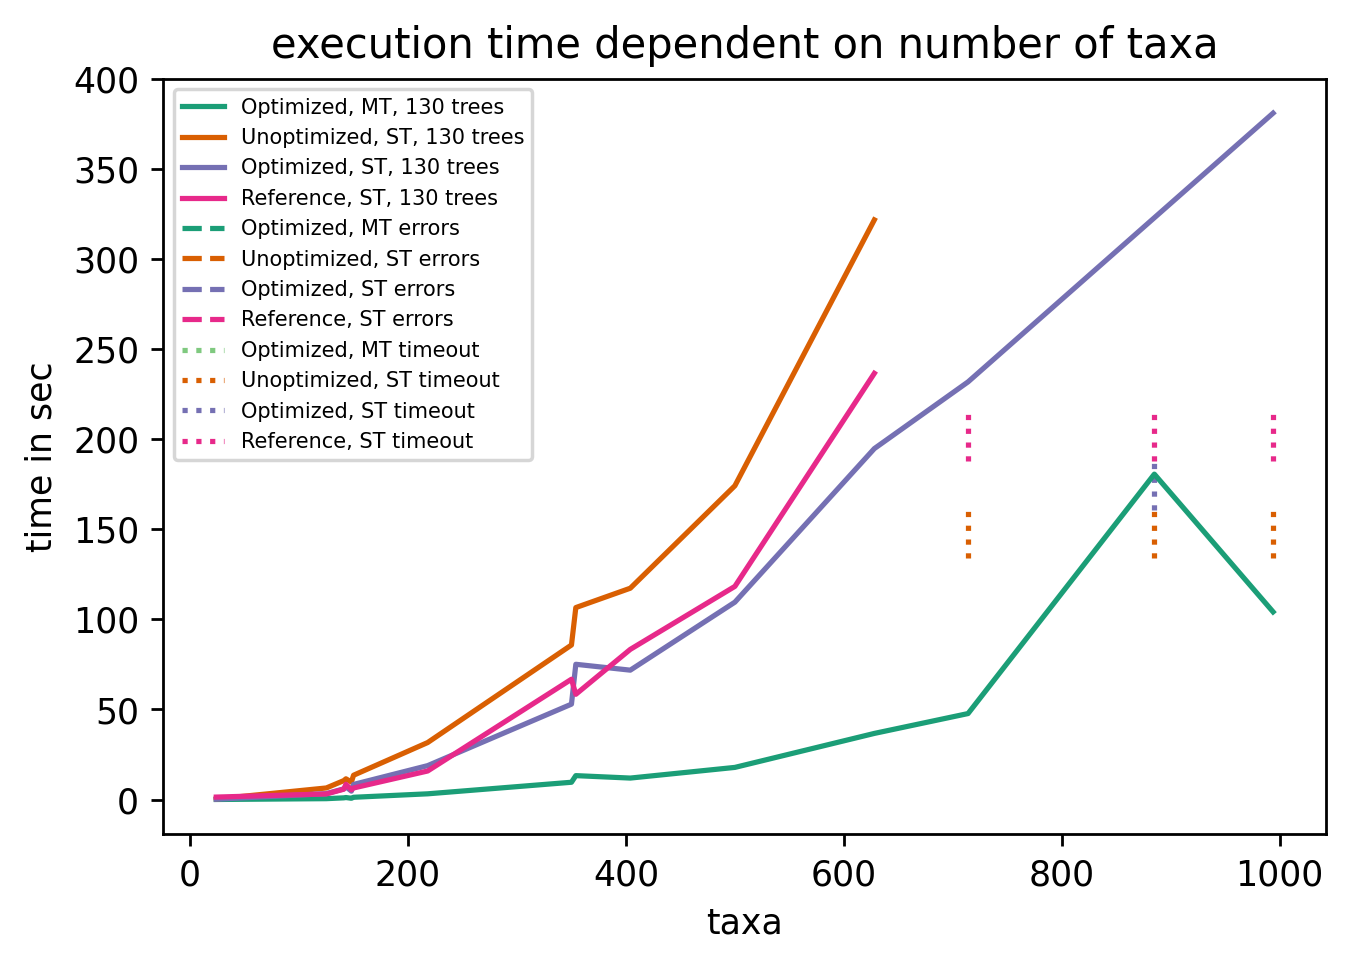

In [7]:
# plot contribution of taxa count

#need to get rid of invalid executions; np.all filters all metrics if one failed
for i, trees in enumerate(tree_values):
    # filter metrics where at least one is invalid
    invM_opt = np.all(getInvalidMask(opt[i,:,:]),axis=1)
    invM_unopt = np.all(getInvalidMask(unopt[i,:,:]),axis=1)
    invM_sth = np.all(getInvalidMask(singleTh[i,:,:]),axis=1)
    invM_ref = np.all(getInvalidMask(ref[i,:,:]),axis=1)

    noZeros_opt = np.average(opt[i,invM_opt,:],axis=1)
    noZeros_unopt = np.average(unopt[i,invM_unopt,:],axis=1)
    noZeros_sth = np.average(singleTh[i,invM_sth,:],axis=1)
    noZeros_ref = np.average(ref[i,invM_ref,:],axis=1)

    # plot calculations
    plt.plot(num_taxa[invM_opt], noZeros_opt, label = f"Optimized, MT, {trees} trees", color='#1b9e77')
    plt.plot(num_taxa[invM_unopt], noZeros_unopt, label = f"Unoptimized, ST, {trees} trees", color='#d95f02')
    plt.plot(num_taxa[invM_sth], noZeros_sth, label = f"Optimized, ST, {trees} trees", color='#7570b3')
    plt.plot(num_taxa[invM_ref], noZeros_ref, label = f"Reference, ST, {trees} trees", color='#e7298a')

    
    # plot errors
    memMask_opt =  np.all(getErrMask(opt),axis=2)[i,:]
    memMask_unopt =  np.all(getErrMask(unopt),axis=2)[i,:]
    memMask_sth =  np.all(getErrMask(singleTh),axis=2)[i,:]
    memMask_ref = np.all(getErrMask(ref),axis=2)[i,:]
    
    maxV = np.max(noZeros_unopt) / 4. / 3.

    def plotVline(x_vals, i, lab, col, isTimeout):
        lStyle = 'dashed'
        if isTimeout:
            lStyle = 'dotted'
        plt.vlines(x_vals, i*maxV, (i+1)*maxV, label=lab, linestyle=lStyle, color=col)
    
    plotVline(num_taxa[~memMask_opt], 0.0, "Optimized, MT errors", '#1b9e77', False)
    plotVline(num_taxa[~memMask_unopt], 1.0, "Unoptimized, ST errors", '#d95f02', False)
    plotVline(num_taxa[~memMask_sth], 2.0, "Optimized, ST errors", '#7570b3', False)
    plotVline(num_taxa[~memMask_ref], 3.0, "Reference, ST errors", '#e7298a', False)
    

    tMask_opt =  np.all(getTimeoutMask(opt),axis=2)[i,:]
    tMask_unopt =  np.all(getTimeoutMask(unopt),axis=2)[i,:]
    tMask_sth =  np.all(getTimeoutMask(singleTh),axis=2)[i,:]
    tMask_ref =  np.all(getTimeoutMask(ref),axis=2)[i,:]


    plotVline(num_taxa[~tMask_opt], 4.0, "Optimized, MT timeout", '#7fc97f', True)
    plotVline(num_taxa[~tMask_unopt], 5.0, "Unoptimized, ST timeout", '#d95f02', True)
    plotVline(num_taxa[~tMask_sth], 6.0, "Optimized, ST timeout", '#7570b3', True)
    plotVline(num_taxa[~tMask_ref], 7.0, "Reference, ST timeout", '#e7298a', True)

    
    plt.title("execution time dependent on number of taxa")
    plt.ylabel("time in sec")
    plt.xlabel("taxa")
    plt.legend(loc=2, prop={'size':6})
    plt.savefig(plot_store_path+str(trees)+"treesPerf",dpi=300,facecolor='white', transparent=False )
    plt.show()


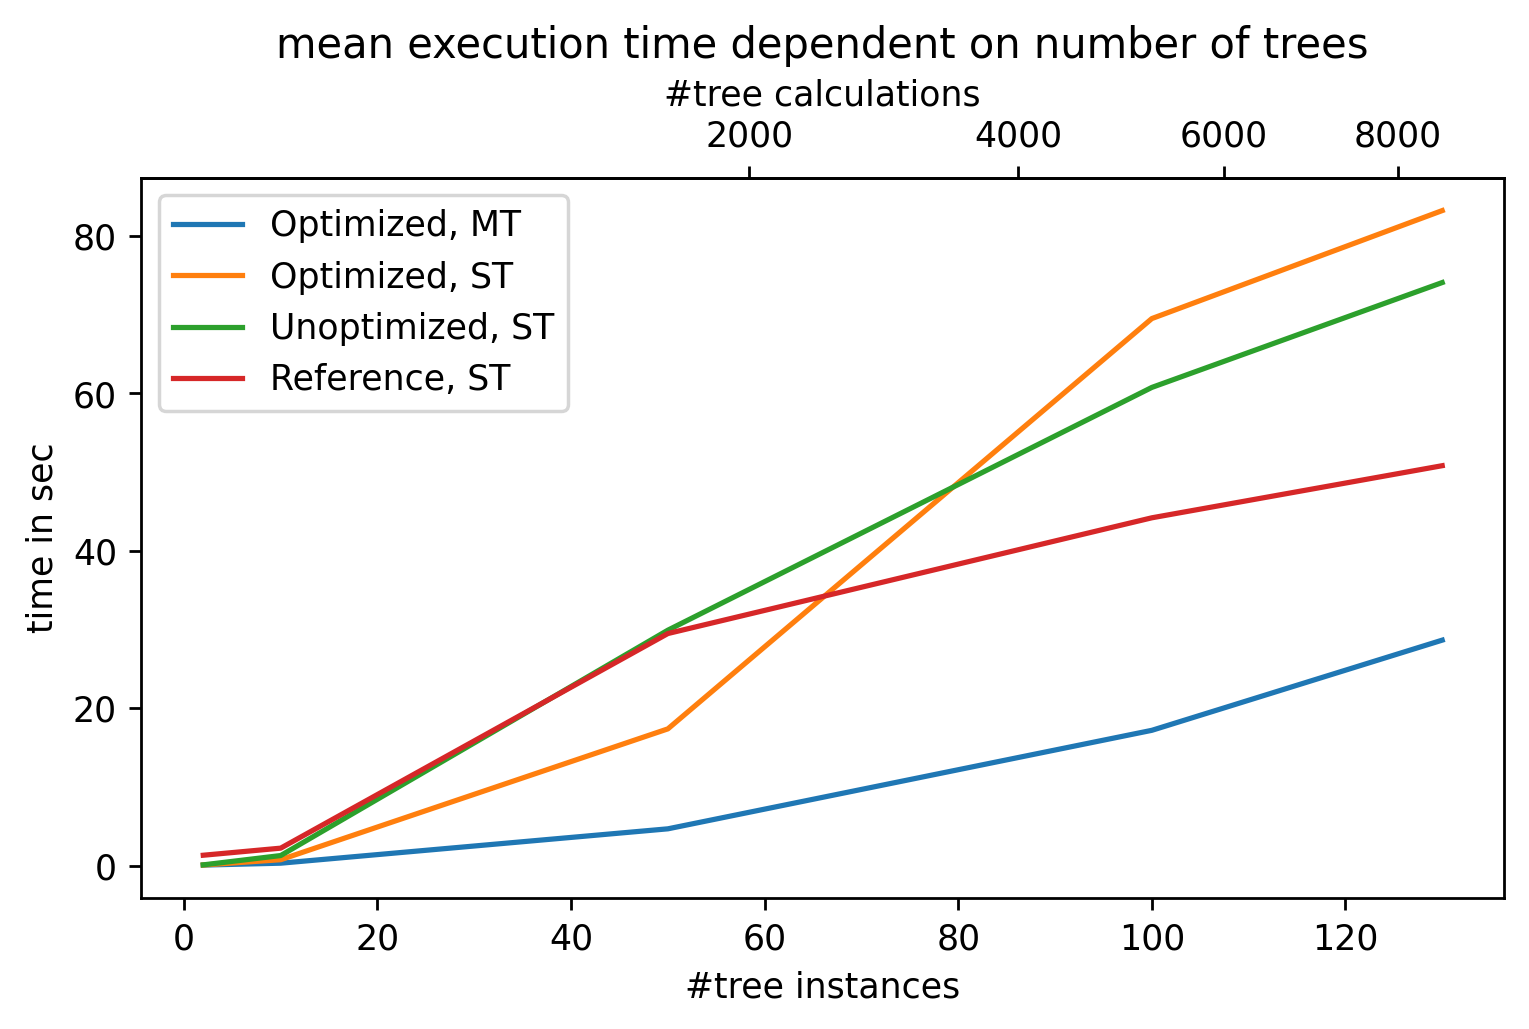

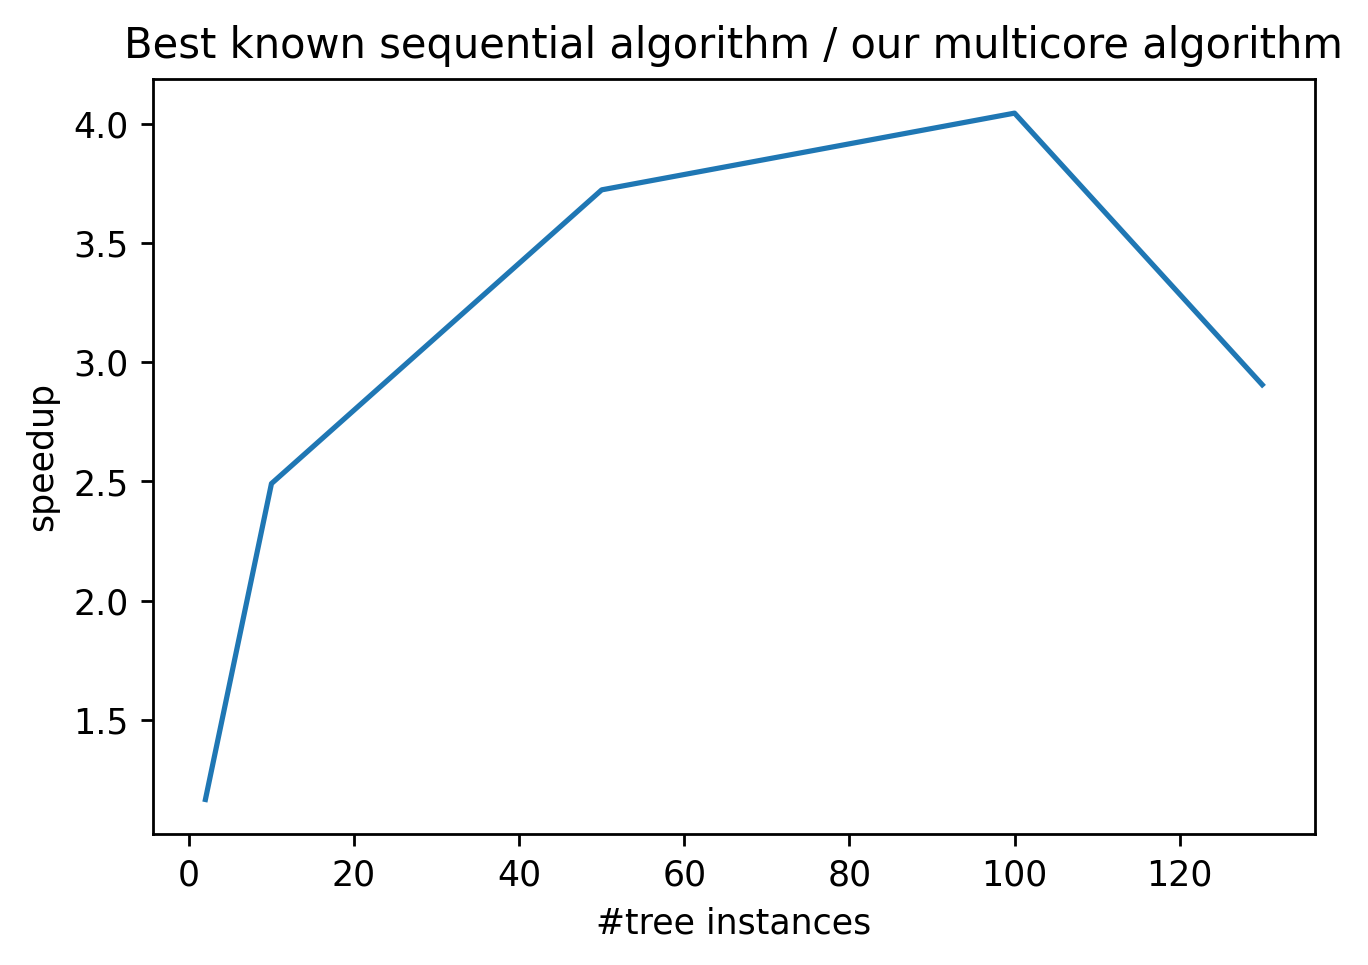

In [8]:
# plot contribution of tree count
tree_calcs = tree_values
#get first timeout event to compare fair measures
max_idx = min(np.argmax(~tMask_opt),np.argmax(~tMask_unopt),np.argmax(~tMask_sth),np.argmax(~tMask_ref))

invM_opt = np.all(getInvalidMask(opt),axis=2)
invM_unopt = np.all(getInvalidMask(unopt),axis=2)
invM_sth = np.all(getInvalidMask(singleTh),axis=2)
invM_ref = np.all(getInvalidMask(ref),axis=2)

if max_idx != 0 or ~tMask_opt[0] or ~tMask_unopt[0] or ~tMask_ref[0] or ~tMask_sth[0]:
    invM_opt[:,max_idx:] = False
    invM_unopt[:,max_idx:] = False
    invM_sth[:,max_idx:] = False
    invM_ref[:,max_idx:] = False

tree_avgs_opt = []
tree_avgs_unopt = []
tree_avgs_sth = []
tree_avgs_ref = []


for idx,tree in enumerate(tree_values):
    filtered_opt = opt[idx,:,:]
    tree_avgs_opt.append(np.average(filtered_opt[invM_opt[idx,:]]))

    filtered_unopt = unopt[idx,:,:]
    tree_avgs_unopt.append(np.average(filtered_unopt[invM_unopt[idx,:]]))
    
    filtered_sth = singleTh[idx,:,:]
    tree_avgs_sth.append(np.average(filtered_sth[invM_sth[idx,:]]))
    
    filtered_ref = ref[idx,:,:]
    tree_avgs_ref.append(np.average(filtered_ref[invM_ref[idx,:]]))

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(tree_calcs,tree_avgs_opt, label="Optimized, MT")
ax.plot(tree_calcs,tree_avgs_sth, label="Optimized, ST")
ax.plot(tree_calcs,tree_avgs_unopt, label="Unoptimized, ST")
ax.plot(tree_calcs,tree_avgs_ref, label="Reference, ST")

ax.set_xlabel("#tree instances")
def trees2calc(trees):
    return trees * (trees+1)/2
def calc2trees(calc):
    return 0.5 * (np.sqrt(8*calc+1)-1)

secax = ax.secondary_xaxis('top', functions=(trees2calc, calc2trees))
secax.set_xlabel("#tree calculations")

plt.title("mean execution time dependent on number of trees")
plt.ylabel("time in sec")
plt.legend()
plt.savefig(plot_store_path+"timePerTreeCalc",dpi=300,facecolor='white', transparent=False )
plt.show()

plt.plot(tree_calcs, 1/np.array(tree_avgs_opt)*np.array(tree_avgs_sth), label="speedup")
plt.xlabel("#tree instances")
plt.ylabel("speedup")
plt.title("Best known sequential algorithm / our multicore algorithm")
plt.savefig(plot_store_path+"speedup",dpi=300,facecolor='white', transparent=False )
plt.show()